# A preliminary look at sensor data

The general idea of the project is to get a handle on how the house heats and cools so that we can better program the thermostat.

To gather data, I've assembled and programmed 5 probes using inexpensive hardware ([Wemos D1 Mini](https://wiki.wemos.cc/products:d1:d1_mini) ESP8266 Wifi boards and [SHT30](https://wiki.wemos.cc/products:d1_mini_shields:sht30_shield) temperature/humidity sensors). The intent is to move the probes around the house to help us tune the thermostat.

Here, I look at several hours of data from an initial test run. The probes were colocated, but not identically oriented.

The initial version of software connected probes to the house WiFi at startup, but not if WiFi dropped out. And there was a hiccup, and all of the probes stopped reporting. Fortunately, I was able to get a decent data sample.

The probes report temperature and humidity readings every 30 seconds or so, along with the probe's WiFi MAC address. The web server on a spare laptop collects the data, adds a timestamp, and appends to a .csv file. (Eventually, data will go into a database, but flat files are fine for getting started.)

Here's what we're starting with

In [1]:
!head -5 temps.csv

2017-09-10T15:19:05.517506,5C:CF:7F:4C:60:B7,83.73,55.87
2017-09-10T15:19:13.114782,5C:CF:7F:33:F7:F8,83.12,58.14
2017-09-10T15:19:13.122111,5C:CF:7F:4C:5F:2B,84.43,54.29
2017-09-10T15:19:16.995463,5C:CF:7F:34:00:63,86.41,51.70
2017-09-10T15:19:21.512616,2C:3A:E8:0E:DE:A0,86.91,51.39


Some prelimaries. Import code, and configure chart sizes to be larger than the default.

In [2]:
%matplotlib inline
import matplotlib
matplotlib.rcParams['figure.figsize'] = (12, 5)
import pandas as pd

Load the .csv into a pandas DataFrame, adding column names.

In [3]:
df = pd.read_csv('temps.csv', header=None, names=['time', 'mac', 'f', 'h'], parse_dates=[0])
df.head()

,time,mac,f,h
0,2017-09-10 15:19:05.517506,5C:CF:7F:4C:60:B7,83.73,55.87
1,2017-09-10 15:19:13.114782,5C:CF:7F:33:F7:F8,83.12,58.14
2,2017-09-10 15:19:13.122111,5C:CF:7F:4C:5F:2B,84.43,54.29
3,2017-09-10 15:19:16.995463,5C:CF:7F:34:00:63,86.41,51.70
4,2017-09-10 15:19:21.512616,2C:3A:E8:0E:DE:A0,86.91,51.39


A quick plot to get a rough idea of how the sensors differ.

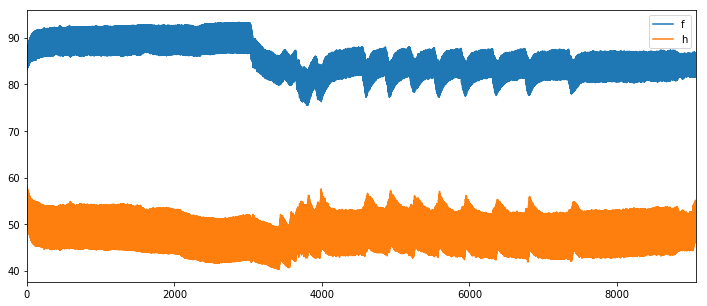

In [4]:
df.plot();

Aside from a wider spread in sensor values than I'd like, and higher temperatures (the room wasn't that hot!), this is roughly what I expected for the temperature pattern. It was a hot, humid day. The bedroom starts off warm, cools when I turned on A/C at 9pm, then oscillates during the night as the A/C kicks in on a scheduled setting.

I didn't know what to expect for humidity.

To get per-sensor plots, the data needs to be reorganized so that each probe is in a different column. This'll need to be done for temperature and humidity independently. Temperature first, since that's what I'm interested in.

In [5]:
per_sensor_f = df.pivot(index='time', columns='mac', values='f')
per_sensor_f.head()

mac,2C:3A:E8:0E:DE:A0,5C:CF:7F:33:F7:F8,5C:CF:7F:34:00:63,5C:CF:7F:4C:5F:2B,5C:CF:7F:4C:60:B7
time,,,,,
2017-09-10 15:19:05.517506,NaN,NaN,NaN,NaN,83.73
2017-09-10 15:19:13.114782,NaN,83.12,NaN,NaN,NaN
2017-09-10 15:19:13.122111,NaN,NaN,NaN,84.43,NaN
2017-09-10 15:19:16.995463,NaN,NaN,86.41,NaN,NaN
2017-09-10 15:19:21.512616,86.91,NaN,NaN,NaN,NaN


This is roughly what's needed, except for the NaN (missing) values. Resampling the data into 2 minute buckets deals with those.

In [6]:
downsampled_f = per_sensor_f.resample('2T').mean()
downsampled_f.head()

mac,2C:3A:E8:0E:DE:A0,5C:CF:7F:33:F7:F8,5C:CF:7F:34:00:63,5C:CF:7F:4C:5F:2B,5C:CF:7F:4C:60:B7
time,,,,,
2017-09-10 15:18:00,86.985000,83.2350,86.830000,84.910000,84.1900
2017-09-10 15:20:00,88.083333,83.8375,88.550000,87.293333,86.5550
2017-09-10 15:22:00,89.272500,84.4700,89.643333,89.145000,88.3900
2017-09-10 15:24:00,89.872500,84.8975,90.215000,90.292500,89.4125
2017-09-10 15:26:00,90.230000,85.0050,90.815000,90.863333,89.9550


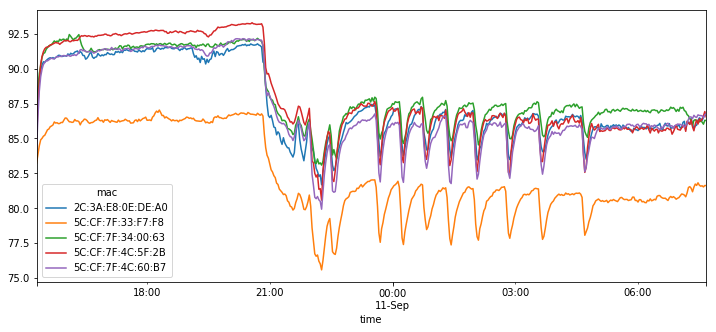

In [7]:
downsampled_f.plot();

The first thing that jumps out is that one of the sensor ~5 degrees lower than the others. The SHT30 sensors are inexpensive; it might be a manufacturing problem, or I might have damaged one while soldering on the headers. (Or maybe it's the sane one, and the other four are measuring hot.)

There also seems to be a 20-30 minute warmup period. I suspect here that a probe, being basically a small computer with stuff attached, is generating its own heat, and the chart shows the slow warm-up. That might also explain why temperatures were higher than expected.

Let's try adding 5F to the suspect sensor's temperature reading to bring it in line with the others.

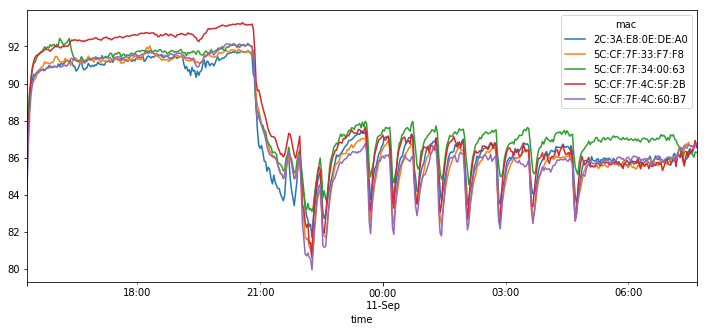

In [8]:
downsampled_f['5C:CF:7F:33:F7:F8'] += 5.0
downsampled_f.plot();

That looks promising.

Next, reorganize the data so that we plot humidity. I'm not as interested in humidity, since it's not as easily controlled, but hey, it's data!

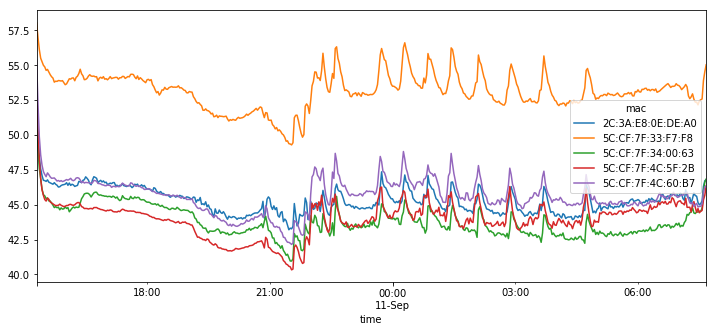

In [9]:
per_sensor_h = df.pivot(index='time', columns='mac', values='h')
downsampled_h = per_sensor_h.resample('2T').mean()
downsampled_h.plot();

That same sensor is the outlier. Eyeballing the graph, that sensor's humidity reading looks high by about 9 units.

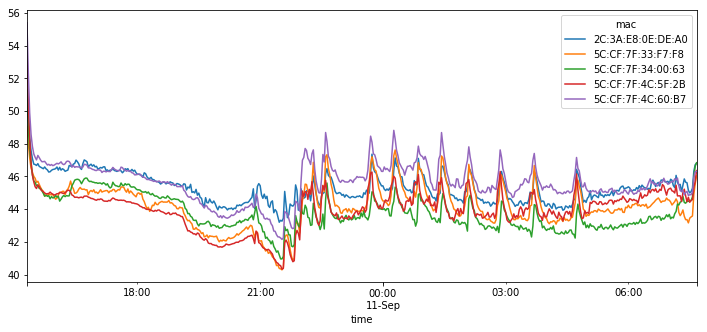

In [10]:
downsampled_h['5C:CF:7F:33:F7:F8'] -= 9.0
downsampled_h.plot();

Also promising.

## Next Steps

First, fix the probes to reconnect to the WiFi if the connection drops.

Next, build a physical test harness so that the sensors are aligned and getting approximately identical airflow (and are somewhat isolated from any heat generated by the CPU/WiFi chipset). An excuse to reach for foam core board and the hot glue gun!

Then, gather another dataset, and use that to calculate per-sensor adjustments. I'll calibrate against a known-good thermometer if I can lay my hands on one.

I might replace the errant sensor, but the lead time for sourcing the parts is a nuisance. If naive math is sufficient to fix values, I'll go with that.